In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from unidip import UniDip
from sklearn.mixture import GaussianMixture

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import decode_static

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [3]:
rois = [roi.lower() for roi in ['PO', 'LP', 'DG', 'CA1', 'VIS']]

In [4]:
behave_dict = data_preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, _, wheel_speed, _, _, _ = data_preprocess.preprocess_dynamic_behaviors(behave_dict)

decode all regions

In [8]:
sorted_trials, _, stim_on_times, np1_channel_map= data_preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_sorted = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_sorted, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
sorted neural data shape: (265, 514, 30)


In [84]:
def generate_predict_matrix(
    neural_data, 
    n_trials, 
    n_time_bins = 30, 
    window_size = 7, 
    aggregate = False
):
    '''
    
    '''
    half_window_size = window_size // 2
    n_windows = n_time_bins - half_window_size + 1 \
        if window_size % 2 == 1 else n_time_bins - half_window_size + 2
    
    windowed_neural_data = []
    for i in range(n_trials):
        for j in range(half_window_size, n_windows):
            window = [j-half_window_size, j+half_window_size-1] \
                if window_size % 2 == 0 else [j-half_window_size, j+half_window_size]
            if aggregate:
                neural_data_per_window = neural_data[:,i,window[0]:window[1]].sum(1)
            else:
                neural_data_per_window = neural_data[:,i,window[0]:window[1]].flatten()
            windowed_neural_data.append(neural_data_per_window)

    windowed_neural_data = np.vstack(windowed_neural_data).reshape(n_trials, -1)

    return windowed_neural_data, half_window_size, n_windows

In [121]:
windowed_sorted_neural_data, half_window_size, n_windows = generate_predict_matrix(
    sorted_neural_data.transpose([1,0,2]), 
    n_trials,
    window_size = 7
)
windowed_wheel_speed = wheel_speed[:,half_window_size:n_windows]

In [70]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold

def decode_dynamic(x_train, x_test, y_train, y_test, behave_type, seed=666):
    '''

    '''
    
    if behave_type in ['motion energy', 'wheel velocity', 'wheel speed',
                       'paw speed', 'nose speed', 'pupil diameter']:
        decoder = Ridge(alpha=2e3).fit(x_train, y_train)
        preds = decoder.predict(x_test)
        r2 = r2_score(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
    return r2, rmse, preds

In [73]:
def cv_decode_dynamic(x, y, behave_type, n_folds=5, seed=666, shuffle=True):
    '''
    
    '''
    
    kf = KFold(n_splits=n_folds, random_state=seed, shuffle=shuffle)
    
    fold = 0
    cv_r2s = []; cv_rmses = []
    cv_ids = []; cv_obs = []; cv_preds = []
    for train, test in kf.split(x, y):
        fold += 1
        r2, rmse, preds = decode_dynamic(x[train], x[test], y[train], y[test], behave_type, seed)
        cv_r2s.append(r2)
        cv_rmses.append(rmse)
        cv_ids.append(test)
        cv_obs.append(y[test])
        cv_preds.append(preds)
        print(f'{behave_type} fold {fold} test r2: {r2:.3f} r2: {r2:.3f}: {rmse:.3f}')
    print(f'{behave_type} mean of {fold}-fold cv r2: {np.mean(cv_r2s):.3f} rmse: {np.mean(cv_rmses):.3f}')
    print(f'{behave_type} sd of {fold}-fold cv r2: {np.std(cv_r2s):.3f} rmse: {np.std(cv_rmses):.3f}')
    
    return cv_r2s, cv_rmses, cv_ids, cv_obs, cv_preds

In [143]:
cv_r2s, _, cv_ids, cv_obs, cv_preds = cv_decode_dynamic(
    windowed_sorted_neural_data, 
    windowed_wheel_speed, 
    behave_type='wheel speed', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

wheel speed fold 1 test r2: 0.188 r2: 0.188: 0.911
wheel speed fold 2 test r2: 0.115 r2: 0.115: 0.802
wheel speed fold 3 test r2: 0.140 r2: 0.140: 0.726
wheel speed fold 4 test r2: 0.133 r2: 0.133: 0.721
wheel speed fold 5 test r2: 0.139 r2: 0.139: 0.806
wheel speed mean of 5-fold cv r2: 0.143 rmse: 0.793
wheel speed sd of 5-fold cv r2: 0.024 rmse: 0.069


In [141]:
cv_r2s, _, cv_ids, cv_obs, cv_preds = cv_decode_dynamic(
    sorted_neural_data.reshape(-1, sorted_neural_data.shape[1]*sorted_neural_data.shape[-1]), 
    wheel_speed, 
    behave_type='wheel speed', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

wheel speed fold 1 test r2: 0.181 r2: 0.181: 0.862
wheel speed fold 2 test r2: 0.111 r2: 0.111: 0.782
wheel speed fold 3 test r2: 0.153 r2: 0.153: 0.693
wheel speed fold 4 test r2: 0.152 r2: 0.152: 0.690
wheel speed fold 5 test r2: 0.147 r2: 0.147: 0.771
wheel speed mean of 5-fold cv r2: 0.149 rmse: 0.760
wheel speed sd of 5-fold cv r2: 0.022 rmse: 0.064


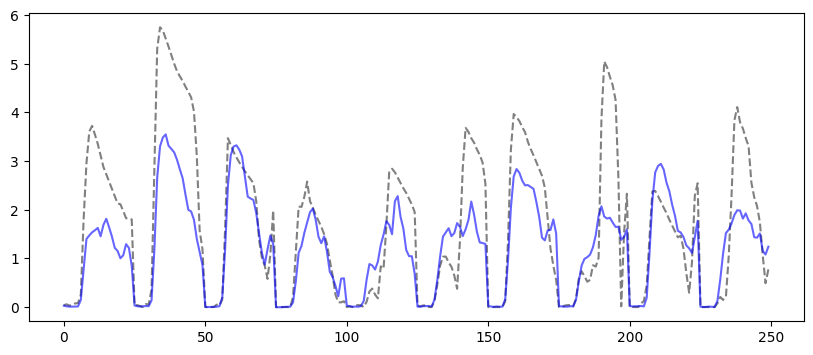

In [144]:
plt.figure(figsize=(10, 4))
plt.plot(np.hstack([cv_obs[0][i] for i in range(0, 50, 5)]), 
         c='gray', linestyle='dashed', label='observed');
plt.plot(np.hstack([cv_preds[0][i] for i in range(0, 50, 5)]), 
         c='blue', alpha=.6, label='predicted');

In [49]:
unsorted_trials, stim_on_times, np1_channel_map = data_preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_unsorted = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=False
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24
thresholded neural data shape: (265, 384, 30)


In [ ]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/init_max_chan_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=False
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

In [ ]:
neural_data_dict = {
    'sorted': sorted_neural_data,
    'thresholded': thresholded_neural_data,
    'clusterless': clusterless_neural_data
} 

In [ ]:
all_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in all_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decode_static.cv_decode_static(
            neural_data_dict[data_type], 
            static_behaviors[behave_type], 
            behave_type=behave_type, 
            n_folds=5, 
            seed=seed, 
            shuffle=True)
        all_decode_results[behave_type].update({data_type: decode_results})
# np.save(f'{save_path}/all_decode_results.npy', all_decode_results)

decode brain regions

In [ ]:
roi = rois[4]
print(roi)

In [ ]:
sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= data_preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=True,
    triage=False
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_sorted = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_sorted, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=True
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

In [ ]:
unsorted_trials, stim_on_times, np1_channel_map = data_preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi=roi,
    kilosort=False,
    triage=False
)

n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times_unsorted = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=30,
    regional=True
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

In [ ]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/init_max_chan_gmm'
means = np.load(gmm_name + '_means.npy')
covar = np.load(gmm_name + '_covariances.npy')
loaded_gmm = GaussianMixture(n_components=len(means), covariance_type='full')
loaded_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(covar))
loaded_gmm.weights_ = np.load(gmm_name + '_weights.npy')
loaded_gmm.means_ = means
loaded_gmm.covariances_ = covar

spike_labels = loaded_gmm.predict(spike_features)
spike_probs = loaded_gmm.predict_proba(spike_features)

clusterless_neural_data = data_preprocess.compute_neural_activity(
    (spike_times_unsorted, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30,
    regional=True
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

In [ ]:
neural_data_dict = {
    'sorted': sorted_neural_data,
    'thresholded': thresholded_neural_data,
    'clusterless': clusterless_neural_data
} 

In [ ]:
regional_decode_results = {'choice': dict(), 'stimulus': dict()}

for behave_type in regional_decode_results.keys():
    for data_type in neural_data_dict.keys():
        print(f'{data_type}:')
        decode_results = decode_static.cv_decode_static(
            neural_data_dict[data_type], 
            static_behaviors[behave_type], 
            behave_type=behave_type, 
            n_folds=5, 
            seed=seed, 
            shuffle=True)
        regional_decode_results[behave_type].update({data_type: decode_results})
# np.save(f'{save_path}/{roi}_decode_results.npy', regional_decode_results)

plotting